# Support Vector Classification 

## The Pima Indian diabetes

We want to predict whether a vector of text features corresponds to a patient having diabetes

### Attribute Information:

Patterns have 8 numeric features plus a 0-1 class label.

1. Number of times pregnant 
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test 
3. Diastolic blood pressure (mm Hg) 
4. Triceps skin fold thickness (mm) 
5. 2-Hour serum insulin (mu U/ml) 
6. Body mass index (weight in kg/(height in m)^2) 
7. Diabetes pedigree function 
8. Age (years) 
9. Class variable (0 or 1) 


More details and actual data available in https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3)

### Loading Data

In [3]:
f_name = 'pima.csv'
df_pima = pd.read_csv(f_name, sep=',')

print( "num_rows: %d\tnum_columns: %d\n" % (df_pima.shape[0], df_pima.shape[1]) )
print( "Column names:\n", list(df_pima.columns) )

vars_pima   = list(df_pima.columns[ : -1])
target_pima = df_pima.columns[-1]

num_rows: 768	num_columns: 9

Column names:
 ['numPregnant', 'glucose', 'bloodPress', 'skinThick', 'insulin', 'massIndex', 'pedigree', 'age', 'label']


### Data Exploration, Visualization and Correlations

Descriptive statistics, boxplots and histograms

In [4]:
########## basic feature stats

df_pima.describe()

,numPregnant,glucose,bloodPress,skinThick,insulin,massIndex,pedigree,age,label
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Removing patients with anomalous features.

How many 0-valued are?

In [5]:
idx_blood_press_ok = df_pima['bloodPress'].values > 0.
idx_glucose_ok = df_pima['glucose'].values > 0.
idx_massIndex_ok = df_pima['massIndex'].values > 0.
idx_skin_ok = df_pima['skinThick'].values > 0.

for idx in [idx_blood_press_ok, idx_glucose_ok, idx_massIndex_ok, idx_skin_ok]:
    print(np.logical_not(idx).sum())

35
5
11
227


Eliminamos la columna `skinThick` y los 0 values del resto

In [6]:
idx_blood_press_ok = df_pima['bloodPress'].values > 0.
idx_glucose_ok = df_pima['glucose'].values > 0.
idx_massIndex_ok = df_pima['massIndex'].values > 0.
#idx_skin_ok = df_pima['skinThick'].values > 0.

idx_ok_all = idx_blood_press_ok
for idx in [idx_glucose_ok, idx_massIndex_ok]:
    idx_ok_all = np.logical_and(idx_ok_all, idx)
    print(idx_ok_all.sum())

728
724


In [7]:
df_pima = df_pima.loc[ idx_ok_all ]
df_pima.drop(labels=['skinThick'], axis='columns', inplace=True)
vars_pima.remove('skinThick')

df_pima.describe().T

,count,mean,std,min,25%,50%,75%,max
numPregnant,724.0,3.866022,3.362803,0.000,1.000,3.000,6.0000,17.00
glucose,724.0,121.882597,30.750030,44.000,99.750,117.000,142.0000,199.00
bloodPress,724.0,72.400552,12.379870,24.000,64.000,72.000,80.0000,122.00
insulin,724.0,84.494475,117.016513,0.000,0.000,48.000,130.5000,846.00
massIndex,724.0,32.467127,6.888941,18.200,27.500,32.400,36.6000,67.10
pedigree,724.0,0.474765,0.332315,0.078,0.245,0.379,0.6275,2.42
age,724.0,33.350829,11.765393,21.000,24.000,29.000,41.0000,81.00
label,724.0,0.343923,0.475344,0.000,0.000,0.000,1.0000,1.00


### Feature pairplots and class histograms

E:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


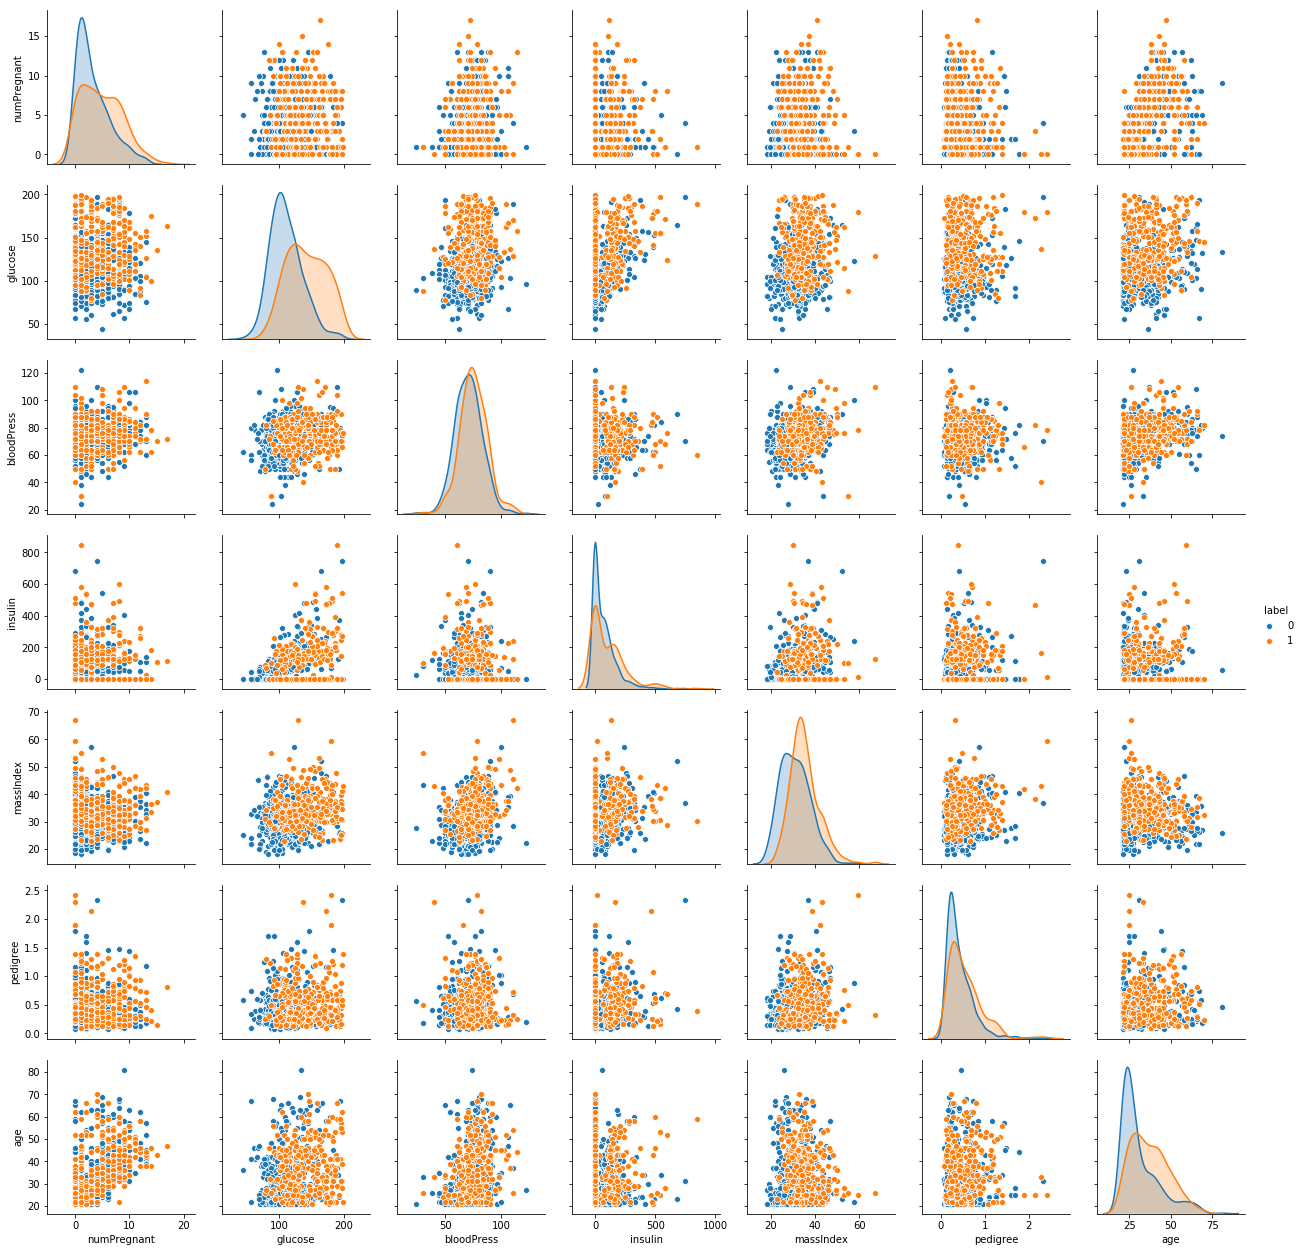

In [8]:
pair_plot = sns.pairplot( df_pima, vars=vars_pima, hue= 'label', diag_kind="kde", diag_kws=dict(shade=True))
plt.show()

## Logistic Regression Classifier

### Data matrix and target vector

In [9]:
x = df_pima[ vars_pima ].values
y = df_pima[ target_pima ].values
num_patterns, dim = x.shape

### `C` hyperparameterization

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

sc = StandardScaler()
x_sc = sc.fit_transform(x)

l_C     = [10.**k for k in range(-1, 6)] 
param_grid ={'C': l_C}

n_folds = 5
skf = StratifiedKFold(n_folds, shuffle=True)

logr = LogisticRegression(solver='lbfgs', max_iter=500)

C_search = GridSearchCV(logr, 
                        param_grid=param_grid, 
                        cv=skf, 
                        scoring='accuracy', 
                        refit=True,
                        n_jobs=2,
                        return_train_score=True,
                        verbose=1)

t_0 = time.time()
C_search.fit(x, y)
print("grid_search_time:", time.time() - t_0)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  35 out of  35 | elapsed:    8.7s finished


grid_search_time: 8.974554061889648


### Best model performance

In [11]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedShuffleSplit, cross_validate

logr_best = C_search.best_estimator_

n_splits = 10
test_size=0.25
scoring = ['accuracy', 'precision', 'recall']   

ssf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
logr_scores = cross_validate(logr_best, x, y, cv=ssf, scoring=scoring)

logr_scores.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_precision', 'train_precision', 'test_recall', 'train_recall'])

In [12]:
print(logr_scores['test_accuracy'].mean())
print(logr_scores['test_recall'].mean())
print(logr_scores['test_precision'].mean())

0.7679558011049723
0.5516129032258065
0.7076866040431148


## SV Classifier

Build a first a pipeline model to be hyperparameterized later.

### Linear SVC
Probamos primero un modelo lineal

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# scaler + svc pipeline
mm_sc = MinMaxScaler()
svc_m = SVC(C=1., 
            kernel='linear', 
            #probability=True,
            shrinking=False, 
            tol=1.e-3)

svc_estimator = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                                ('svc', svc_m)])

t_0 = time.time()
svc_estimator.fit(x, y)
print("train_time:", time.time() - t_0)

train_time: 0.04697871208190918


In [14]:
#dir(svc_estimator)

#### Basic model structure

Explore model properties

In [15]:
svc = svc_estimator.named_steps['svc']

print("num_svs_per_class:", svc.n_support_)
print("indices_of_svs:   ", svc_m.support_)
print("svs_shape:        ", svc_m.support_vectors_.shape)

print("dual_coefs:       ", svc_m.dual_coef_)
print("intercept:        ", svc_m.intercept_)
print("num SVs at bound: ", (abs(svc_m.dual_coef_) == svc.C).sum())
print("num SVs:          ", (np.logical_and(abs(svc_m.dual_coef_) < svc.C, 
                                            abs(svc_m.dual_coef_) > 0.).sum()))

num_svs_per_class: [201 200]
indices_of_svs:    [  8  10  15  17  18  25  26  27  31  33  37  38  41  43  50  53  54  58
  62  64  66  68  78  83  84  86  87  93  97  99 113 115 118 125 127 130
 133 136 138 139 141 144 151 152 153 157 158 159 168 171 173 180 189 192
 199 200 205 210 215 216 220 231 233 234 235 237 245 247 249 251 252 258
 259 262 265 266 269 270 273 278 279 281 283 287 288 296 301 303 308 310
 313 317 323 324 325 326 329 335 338 339 341 350 355 371 377 381 386 388
 389 396 403 407 409 410 412 415 428 431 432 436 440 441 442 443 444 446
 449 450 456 457 459 464 468 471 475 477 485 487 489 491 497 498 503 512
 513 514 517 520 522 523 533 539 540 541 543 547 548 555 558 567 570 575
 581 583 588 589 602 605 611 612 617 618 620 628 629 630 633 634 644 647
 649 651 656 657 658 663 666 667 677 679 681 682 683 684 700 701 703 707
 712 719 720   0   2   6   7  11  12  13  14  16  20  21  22  23  28  34
  35  36  45  56  59  61  65  67  76  80  85  91  92 101 102 103 106 107
 10

### Gaussian SVC

Probamos ahora un modelo rbf

In [16]:
# scaler + svc pipeline
mm_sc = MinMaxScaler()
svc_m = SVC(C=1., 
            gamma=1/dim, 
            kernel='rbf', 
            #probability=True,
            shrinking=False, 
            tol=1.e-3)

svc_estimator = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                                ('svc', svc_m)])

t_0 = time.time()
svc_estimator.fit(x, y)
print("train_time:", time.time() - t_0)

train_time: 0.14590954780578613


#### Basic pipeline model structure

Explore model properties

In [17]:
svc = svc_estimator.named_steps['svc']

print("num_svs_per_class:", svc.n_support_)
print("indices_of_svs:   ", svc_m.support_)
print("svs_shape:        ", svc_m.support_vectors_.shape)

print("dual_coefs:       ", svc_m.dual_coef_)
print("intercept:        ", svc_m.intercept_)
print("num SVs at bound: ", (abs(svc_m.dual_coef_) == svc.C).sum())
print("num SVs:          ", (np.logical_and(abs(svc_m.dual_coef_) < svc.C, 
                                            abs(svc_m.dual_coef_) > 0.).sum()))

num_svs_per_class: [221 220]
indices_of_svs:    [  8  10  15  17  18  25  26  27  31  33  37  38  41  43  50  53  54  58
  62  64  66  68  77  78  83  84  86  87  93  97  99 113 115 118 125 127
 130 131 132 133 136 138 139 141 144 151 152 153 157 158 159 168 171 173
 180 188 189 192 199 200 205 210 215 216 220 231 233 234 235 237 238 243
 245 247 249 251 252 258 259 262 265 266 269 270 273 278 279 281 283 287
 288 294 296 301 303 308 310 313 315 317 321 323 324 325 326 329 335 338
 339 341 350 355 365 368 371 377 381 386 387 388 389 396 403 407 409 410
 412 415 428 431 432 436 440 441 442 443 444 446 448 449 450 452 456 457
 459 464 468 471 475 477 485 487 489 491 497 498 503 512 513 514 517 520
 522 523 533 539 540 541 543 547 548 555 558 567 570 575 578 581 583 588
 589 602 605 611 612 617 618 620 628 629 630 633 634 644 647 649 651 656
 657 658 663 666 667 669 673 677 679 680 681 682 683 684 692 700 701 703
 707 712 719 720 721   0   2   4   6   7   9  11  12  13  14  16  20  21
  2

## Hyperparametrization of C and $\gamma$

### SVC Grid Search CV

In [18]:
l_C     = [10.**k for k in range(-2, 3)] 
l_gamma = list( np.array([2.**k for k in range(-2, 3)]) / dim)

param_grid ={'svc__C': l_C,
             'svc__gamma': l_gamma}

print("num_hyperparams", len(l_C) * len(l_gamma))

n_folds = 5
skf = StratifiedKFold(n_folds, shuffle=True)

C_gamma_search = GridSearchCV(svc_estimator, 
                              param_grid=param_grid, 
                              cv=skf, 
                              scoring='accuracy', 
                              refit=True,
                              n_jobs=2,
                              return_train_score=True,
                              verbose=1)

t_0 = time.time()
C_gamma_search.fit(x, y)
print("grid_search_time:", time.time() - t_0)

num_hyperparams 25
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 122 out of 125 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 125 out of 125 | elapsed:    4.3s finished


grid_search_time: 4.5192155838012695


In [19]:
f_pkl = open("c_gamma_cv_search_pima.plk", 'wb') 
pickle.dump(C_gamma_search, f_pkl)
f_pkl.close()

### Analyze hyperpars

In [20]:
f_pkl = open("c_gamma_cv_search_pima.plk", 'rb') 
C_gamma_search = pickle.load(f_pkl)
f_pkl.close()

In [21]:
best_C = C_gamma_search.best_params_['svc__C']
best_gamma = C_gamma_search.best_params_['svc__gamma']
#best_svc  = svc_C_gamma_search.best_estimator_

print("C\tmin %f" % np.min(l_C), "\tbest %f" % best_C, "\tmax %f" % np.max(l_C))
print("gamma\tmin %.3f" % np.min(l_gamma), "\tbest %.3f" % best_gamma, "\tmax %.3f" % np.max(l_gamma))

C	min 0.010000 	best 1.000000 	max 100.000000
gamma	min 0.036 	best 0.143 	max 0.571


### Performance by hyperpars

Sort by best CV test score

In [22]:
df_C_gamma_search = pd.DataFrame.from_dict(C_gamma_search.cv_results_)

df_C_gamma_search.sort_values(by='mean_test_score', ascending=False)[['param_svc__C', 'param_svc__gamma', 'mean_test_score']][ : 10]

,param_svc__C,param_svc__gamma,mean_test_score
12,1,0.142857,0.777624
14,1,0.571429,0.773481
13,1,0.285714,0.772099
16,10,0.0714286,0.772099
15,10,0.0357143,0.772099
19,10,0.571429,0.767956
20,100,0.0357143,0.766575
22,100,0.142857,0.763812
17,10,0.142857,0.763812
23,100,0.285714,0.762431


### C vs $\gamma$ plot

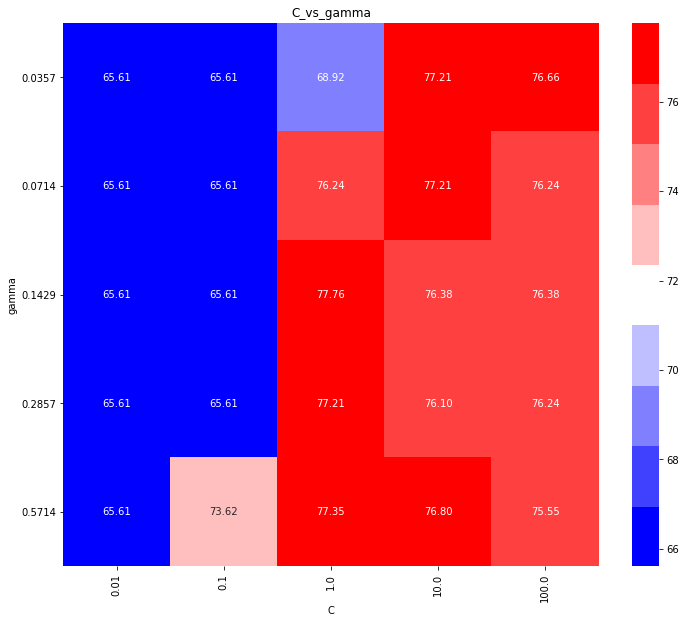

In [23]:
n_colors = 9
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

plt.figure( figsize=(12, 10))
plt.title('C_vs_gamma')

m_t_s = df_C_gamma_search.sort_values(by=['param_svc__gamma', 'param_svc__C'])['mean_test_score'].values.reshape(len(l_gamma), -1)
h_map = sns.heatmap(100.*m_t_s, 
                    cmap=cMap, 
                    annot=True, 
                    fmt=".2f",
                    xticklabels=l_C,
                    yticklabels=np.round(l_gamma, decimals=4))

plt.xlabel('C')
plt.ylabel('gamma')
plt.xticks(rotation='vertical')
plt.yticks(rotation=0)

cbar = h_map.collections[0].colorbar
l_ticks = [100.*(0.6 + k/100.) for k in range(0, 21, 2)]
cbar.set_ticks(l_ticks)

plt.show()

### Structure of best model

In [24]:
best_model = C_gamma_search.best_estimator_
svc_m = best_model.named_steps['svc']

In [25]:
print("num_svs_per_class:", svc_m.n_support_)
#print("svs_per_class:    ", svc_m.support_)
print("dual_coefs:       ", svc_m.dual_coef_)
print("intercep:         ", svc_m.intercept_)

num_svs_per_class: [221 220]
dual_coefs:        [[-1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -0.905 -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
  -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1. 

### Accuracy, recall and precision of best model

In [26]:
scoring = ['accuracy', 'precision', 'recall']   

n_splits = 50
test_size=0.25
ssf = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)

svc_best = C_gamma_search.best_estimator_
svc_scores = cross_validate(svc_best, x, y, cv=ssf, scoring=scoring)

In [27]:
print(svc_scores['test_accuracy'].mean())
print(svc_scores['test_recall'].mean())
print(svc_scores['test_precision'].mean())

0.7790055248618785
0.5316129032258065
0.7518143185206881


#### LogR Comparison

In [28]:
logr_scores = cross_validate(logr_best, x, y, cv=ssf, scoring=scoring)

print(logr_scores['test_accuracy'].mean())
print(logr_scores['test_recall'].mean())
print(logr_scores['test_precision'].mean())

0.7760220994475138
0.5716129032258065
0.7192683895624128


## Predicting probabilities

In classification we should give class probability estimates rather than labels.

To do so, we can build the histogram of the posterior probabilities predicted for the positive class and decide on adequate thresholds.

In [29]:
######### plot prob histograms
svc_best.named_steps['svc'].probability=True

p_pred = cross_val_predict(svc_best, x, y, cv=StratifiedKFold(n_folds, shuffle=True),
                           method='predict_proba')

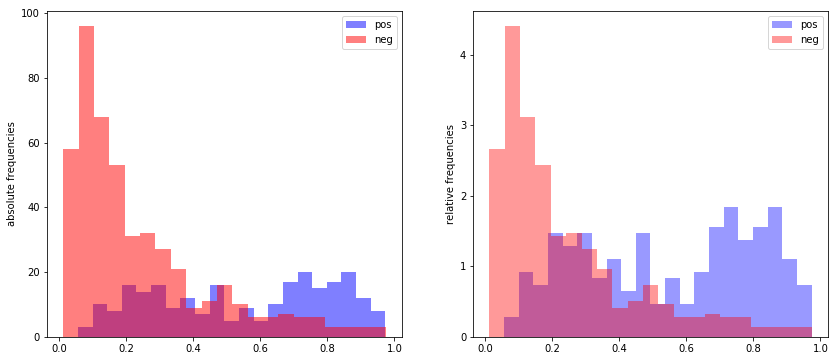

In [30]:
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]

bins = 21

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.ylabel("absolute frequencies")
plt.hist( p_pred[pos, 1], bins=bins, density=False, color='b', label='pos', alpha=0.5)
plt.hist( p_pred[neg, 1], bins=bins, density=False, color='r', label='neg', alpha=0.5)
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.ylabel("relative frequencies")
sns.distplot( p_pred[pos, 1], bins=bins, norm_hist=True, kde=False, color='b', label='pos')
sns.distplot( p_pred[neg, 1], bins=bins, norm_hist=True, kde=False, color='r', label='neg')
plt.legend(loc='best')

plt.show()